In [1]:
%matplotlib inline
import matplotlib
import seaborn as sns

## To do
1. Make the same models as before, but have the "from the loop" and "to the loop" as 2 columns in the same DataFrame.

## Summary

This is the notebook where I build models for taxi traffic based on time.

In [2]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from datetime import datetime, timedelta

In [204]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

In [4]:
df = pd.read_csv('Data/GroupBy.csv')

In [5]:
df.head()

,Unnamed: 0,direction,year,month,day,hour,minute,census_tract,count
0,0,from,2013,1,1,13,15,17031080100,1
1,1,from,2013,1,1,13,15,17031980000,1
2,2,from,2013,1,1,1,30,17031081100,1
3,3,from,2013,1,1,13,45,17031833100,1
4,4,from,2013,1,1,2,0,17031839000,2


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6150668 entries, 0 to 6150667
Data columns (total 9 columns):
Unnamed: 0      int64
direction       object
year            int64
month           int64
day             int64
hour            int64
minute          int64
census_tract    int64
count           int64
dtypes: int64(8), object(1)
memory usage: 422.3+ MB


In [7]:
def make_time(row):
    return datetime(row['year'], row['month'], row['day'],
                    row['hour'], row['minute'])

In [8]:
df['date'] = df.apply(make_time, axis=1)

In [9]:
df_by_date = df[['date', 'direction', 'count']].groupby(['date', 'direction']).sum() \
               .pivot_table(values='count', index=['date'], columns=['direction']).fillna(0)

In [10]:
df_by_date.head()

direction,from,to
date,,
2013-01-01 00:00:00,44.0,45.0
2013-01-01 00:15:00,84.0,62.0
2013-01-01 00:30:00,71.0,87.0
2013-01-01 00:45:00,61.0,75.0
2013-01-01 01:00:00,62.0,63.0


Fill nonexistent rows, to make the rows consistently 15 minutes apart

In [11]:
first_date = datetime(2013, 1, 1)
last_date = datetime(2017, 8, 1)

In [12]:
datetime(2013, 1, 1, 0, 15) - first_date

datetime.timedelta(0, 900)

In [13]:
dates = pd.date_range(start=first_date, end=last_date, freq='15Min')

In [14]:
absent = [date for date in dates
               if date not in df_by_date.index]

In [15]:
df_by_date = pd.concat([df_by_date,
                               pd.DataFrame([[date, 0, 0] for date in absent],
                                            columns=['date', 'from', 'to']).set_index('date')]).sort_index()

Do Fourier transform to see patterns. I expect 24-hour, 7-day, and 365-day frequencies.

In [16]:
from scipy import fftpack

In [17]:
from_fft = fftpack.fft(df_by_date['from'] -
                       df_by_date['from'].mean())

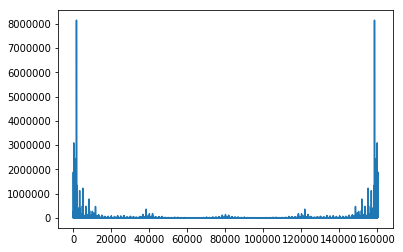

In [18]:
plt.plot(np.abs(from_fft))
plt.show()

There's are big peaks at low frequency. Take a closer look.

In [19]:
freq_year = len(dates) / (365*24*4)
freq_week = len(dates) / (7*24*4)
freq_day = len(dates) / (24*4)

In [20]:
print(freq_year, freq_week, freq_day)

4.583590182648402 239.0014880952381 1673.0104166666667


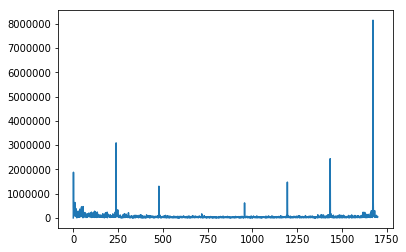

In [21]:
plt.plot(np.abs(from_fft[:1700]))
plt.show()

Similarly for trips to the Loop.

In [22]:
to_fft = fftpack.fft(df_by_date['to'] -
                       df_by_date['to'].mean())

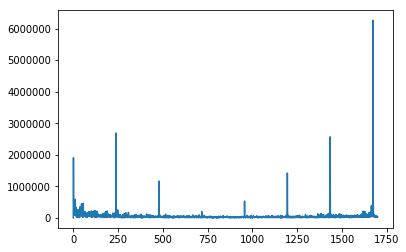

In [23]:
plt.plot(np.abs(to_fft[:1700]))
plt.show()

1 per day gives the biggest Fourier component. The next biggest is the 1 per week frequency.

In [26]:
df_by_date = df_by_date.reset_index()

In [27]:
df_by_date.head()

direction,date,from,to
0,2013-01-01 00:00:00,44.0,45.0
1,2013-01-01 00:15:00,84.0,62.0
2,2013-01-01 00:30:00,71.0,87.0
3,2013-01-01 00:45:00,61.0,75.0
4,2013-01-01 01:00:00,62.0,63.0


In [28]:
#need categories to go from 0 to N-1
df_by_date['tod'] = df_by_date['date'].apply(
                            lambda x: int(4*x.hour + x.minute/15))
df_by_date['dow'] = df_by_date['date'].apply(
                            lambda x: datetime.weekday(x))

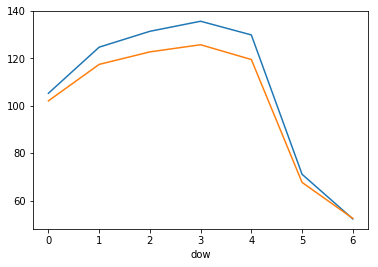

In [29]:
#plot by day of week
df_by_date.groupby('dow').mean()['from'].plot()
df_by_date.groupby('dow').mean()['to'].plot()
plt.show()

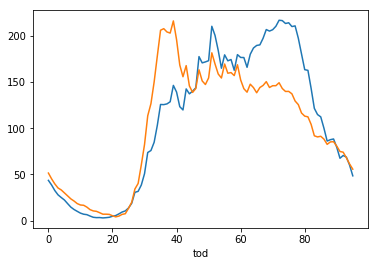

In [30]:
#plot by time of day
df_by_date.groupby('tod').mean()['from'].plot()
df_by_date.groupby('tod').mean()['to'].plot()
plt.show()

Are the hourly peaks during the day associated with people trying to make an appointment on the hour? Plausible but I can't really say for sure. Whether or not it's meaningful signal, this seems like something specific to taxis. It would be good to average over the hour, for most purposes.

The first fit is to do OneHotEncoding of day of week and time of day. Look at the residuals to see what else needs to be fit. Try 2 possibilities.

1. Separately encode day of week (7 columns) and time of day (96 columns)
2. Combine the 2 into one variable that I encode (672 columns)

We should expect the time-of-day patterns to be different on weekends, for example. So 2 seems better, but try both. I have enough data that I shouldn't worry  about overfitting (yet).

In [31]:
ohe = OneHotEncoder()

In [32]:
X1 = ohe.fit_transform(df_by_date[['tod', 'dow']])

In [33]:
lr1_from = LinearRegression()
lr1_from.fit(X1, df_by_date['from'])
lr1_to = LinearRegression()
lr1_to.fit(X1, df_by_date['to'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [34]:
pred1_from = lr1_from.predict(X1)
pred1_to = lr1_to.predict(X1)

In [35]:
print(lr1_from.score(X1, df_by_date['from']))
print(lr1_to.score(X1, df_by_date['to']))

0.740790033151
0.651970535122


In [36]:
residual1_from = df_by_date['from'] - pred1_from
residual1_to = df_by_date['to'] - pred1_to

In [37]:
residual1_from.describe()

count    1.606090e+05
mean     6.142992e-14
std      4.743271e+01
min     -2.306322e+02
25%     -2.921845e+01
50%     -6.243276e+00
75%      3.231919e+01
max      3.086612e+02
Name: from, dtype: float64

In [38]:
residual1_to.describe()

count    1.606090e+05
mean     1.833837e-13
std      5.007505e+01
min     -2.365989e+02
25%     -2.909631e+01
50%     -5.826907e+00
75%      3.142372e+01
max      3.024011e+02
Name: to, dtype: float64

In [39]:
#combine 'tod' and 'dow'
df_by_date['time'] = (24*4*df_by_date['dow'] + df_by_date['tod'])

In [40]:
X2 = ohe.fit_transform(df_by_date[['time']])

In [41]:
lr2_from = LinearRegression()
lr2_from.fit(X2, df_by_date['from'])
lr2_to = LinearRegression()
lr2_to.fit(X2, df_by_date['to'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [42]:
pred2_from = lr2_from.predict(X2)
pred2_to = lr2_to.predict(X2)

In [43]:
print(lr2_from.score(X2, df_by_date['from']))
print(lr2_to.score(X2, df_by_date['to']))

0.840661200951
0.82219906823


This performs considerably better, and it's not surprising. Time-dependence of traffic patterns has to be very different between weekdays and weekends.

In [44]:
residual2_from = df_by_date['from'] - pred2_from
residual2_to = df_by_date['to'] - pred2_to

In [45]:
residual2_from.describe()

count    1.606090e+05
mean    -5.073858e-15
std      3.718886e+01
min     -2.766736e+02
25%     -1.359414e+01
50%     -5.941423e-01
75%      1.550628e+01
max      2.919958e+02
Name: from, dtype: float64

In [46]:
residual2_to.describe()

count    1.606090e+05
mean     1.051013e-14
std      3.579154e+01
min     -3.007615e+02
25%     -1.369456e+01
50%     -3.514644e-01
75%      1.578243e+01
max      2.726276e+02
Name: to, dtype: float64

Record the model results in the DataFrame.

In [47]:
df_by_date['pred1_from'] = pred1_from
df_by_date['pred1_to'] = pred1_to
df_by_date['residual1_from'] = residual1_from
df_by_date['residual1_to'] = residual1_to
df_by_date['pred2_from'] = pred2_from
df_by_date['pred2_to'] = pred2_to
df_by_date['residual2_from'] = residual2_from
df_by_date['residual2_to'] = residual2_to

In [48]:
df_by_date.head()

direction,date,from,to,tod,dow,time,pred1_from,pred1_to,residual1_from,residual1_to,pred2_from,pred2_to,residual2_from,residual2_to
0,2013-01-01 00:00:00,44.0,45.0,0,1,96,61.092129,67.824442,-17.092129,-22.824442,27.470833,35.558333,16.529167,9.441667
1,2013-01-01 00:15:00,84.0,62.0,1,1,97,56.049147,61.553566,27.950853,0.446434,23.280335,29.012552,60.719665,32.987448
2,2013-01-01 00:30:00,71.0,87.0,2,1,98,50.090988,56.104074,20.909012,30.895926,17.920502,24.476987,53.079498,62.523013
3,2013-01-01 00:45:00,61.0,75.0,3,1,99,45.461580,51.719734,15.538420,23.280266,14.615063,19.845188,46.384937,55.154812
4,2013-01-01 01:00:00,62.0,63.0,4,1,100,42.581126,49.587636,19.418874,13.412364,12.928870,17.824268,49.071130,45.175732


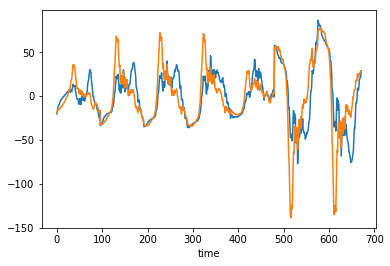

In [49]:
#plot residuals of the 1st model
df_by_date.groupby('time').mean()['residual1_from'].plot()
df_by_date.groupby('time').mean()['residual1_to'].plot()
plt.show()

As expected, the separate OneHotEncoding strategy misses the weekend traffic by a lot. The combined strategy is designed to fit this perfectly.

2 more things to try to use as features in this total traffic model.
1. Holidays
2. Weather

In [50]:
import holidays

In [51]:
USholidays = holidays.UnitedStates()

In [52]:
df_by_date['holiday'] = df_by_date['date'].apply(
                                lambda x: int(x in USholidays))

In [53]:
df_by_date.groupby('holiday').mean()[['residual2_from', 'residual2_to']]

direction,residual2_from,residual2_to
holiday,,
0,1.687769,1.604994
1,-57.138367,-54.336078


Again as expected, holidays have much less taxi traffic than the usual weekdays. Add this as a feature.

In [54]:
X3 = scipy.sparse.hstack((X2, df_by_date[['holiday']]))

In [55]:
lr3_from = LinearRegression()
lr3_from.fit(X3, df_by_date['from'])
lr3_to = LinearRegression()
lr3_to.fit(X3, df_by_date['to'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [56]:
print(lr3_from.score(X3, df_by_date['from']))
print(lr3_to.score(X3, df_by_date['to']))

0.852290391293
0.834868228807


In [57]:
pred3_from = lr3_from.predict(X3)
pred3_to = lr3_to.predict(X3)

In [58]:
residual3_from = df_by_date['from'] - pred3_from
residual3_to = df_by_date['to'] - pred3_to

In [59]:
df_by_date['pred3_from'] = pred3_from
df_by_date['pred3_to'] = pred3_to
df_by_date['residual3_from'] = residual3_from
df_by_date['residual3_to'] = residual3_to

In [60]:
df_by_date[['residual1_from', 'residual1_to',
           'residual2_from', 'residual2_to',
           'residual3_from', 'residual3_to']].describe()

direction,residual1_from,residual1_to,residual2_from,residual2_to,residual3_from,residual3_to
count,1.606090e+05,1.606090e+05,1.606090e+05,1.606090e+05,1.606090e+05,1.606090e+05
mean,6.142992e-14,1.833837e-13,-5.073858e-15,1.051013e-14,-4.295383e-12,-2.450311e-12
std,4.743271e+01,5.007505e+01,3.718886e+01,3.579154e+01,3.580605e+01,3.449282e+01
min,-2.306322e+02,-2.365989e+02,-2.766736e+02,-3.007615e+02,-2.320209e+02,-2.627233e+02
25%,-2.921845e+01,-2.909631e+01,-1.359414e+01,-1.369456e+01,-1.468978e+01,-1.448348e+01
50%,-6.243276e+00,-5.826907e+00,-5.941423e-01,-3.514644e-01,-1.650927e+00,-1.375128e+00
75%,3.231919e+01,3.142372e+01,1.550628e+01,1.578243e+01,1.547460e+01,1.562803e+01
max,3.086612e+02,3.024011e+02,2.919958e+02,2.726276e+02,2.901925e+02,2.709127e+02


Since the holidays make up only a small portion of the data, the overall improvement is small. I could dig into the details and try to incorporate things like Christmas, Thanksgiving (both much less traffic), and Fourth of July (more traffic at times), but that will be more trouble than it is worth. My goal is to model weekdays that are not holidays.

### Weather

In [61]:
df_weather = pd.read_csv('Data/weather.csv').set_index('DATE')

In [62]:
df_weather.head()

,TMAX,TMIN,PRCP,SNOW
DATE,,,,
2013-01-01,26.0,15.0,0.0,0.0
2013-01-02,29.0,14.0,0.0,0.0
2013-01-03,30.0,21.0,0.0,0.0
2013-01-04,37.0,16.0,0.0,0.0
2013-01-05,38.0,25.0,0.0,0.0


Join the weather data

In [63]:
df_by_date['DATE'] = df_by_date['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

In [64]:
#df_by_date = df_by_date.drop(columns=['TMAX', 'TMIN', 'PRCP', 'SNOW'])

In [65]:
df_by_date = df_by_date.join(df_weather, on='DATE')

In [66]:
df_by_date.head()

,date,from,to,tod,dow,time,pred1_from,pred1_to,residual1_from,residual1_to,...,holiday,pred3_from,pred3_to,residual3_from,residual3_to,DATE,TMAX,TMIN,PRCP,SNOW
0,2013-01-01 00:00:00,44.0,45.0,0,1,96,61.092129,67.824442,-17.092129,-22.824442,...,1,-33.331128,-22.261662,77.331128,67.261662,2013-01-01,26.0,15.0,0.0,0.0
1,2013-01-01 00:15:00,84.0,62.0,1,1,97,56.049147,61.553566,27.950853,0.446434,...,1,-37.518407,-28.804380,121.518407,90.804380,2013-01-01,26.0,15.0,0.0,0.0
2,2013-01-01 00:30:00,71.0,87.0,2,1,98,50.090988,56.104074,20.909012,30.895926,...,1,-42.878239,-33.339945,113.878239,120.339945,2013-01-01,26.0,15.0,0.0,0.0
3,2013-01-01 00:45:00,61.0,75.0,3,1,99,45.461580,51.719734,15.538420,23.280266,...,1,-46.183679,-37.971744,107.183679,112.971744,2013-01-01,26.0,15.0,0.0,0.0
4,2013-01-01 01:00:00,62.0,63.0,4,1,100,42.581126,49.587636,19.418874,13.412364,...,1,-47.869871,-39.992665,109.869871,102.992665,2013-01-01,26.0,15.0,0.0,0.0


See if I can pick out any obvious patterns between residuals of the time-only model and weather, from scatter plots.

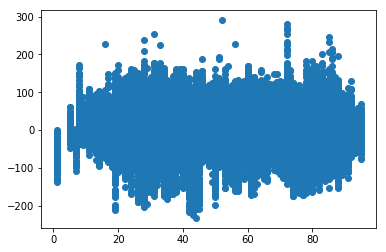

In [67]:
plt.scatter(x=df_by_date['TMAX'], y=df_by_date['residual3_from'])

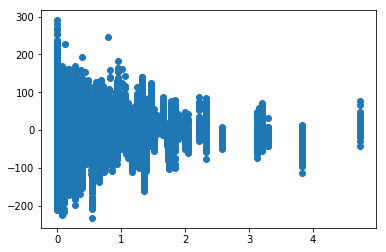

In [68]:
plt.scatter(x=df_by_date['PRCP'], y=df_by_date['residual3_from'])

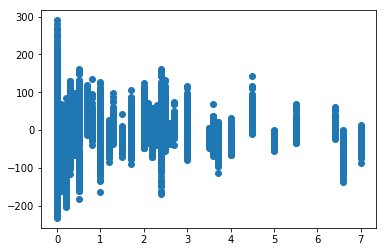

In [69]:
plt.scatter(x=df_by_date['SNOW'], y=df_by_date['residual3_from'])

In [70]:
df_by_date[['TMAX', 'TMIN', 'PRCP', 'SNOW', 'residual3_from', 'residual3_to']].corr()

,TMAX,TMIN,PRCP,SNOW,residual3_from,residual3_to
TMAX,1.000000,0.950942,0.084631,-0.242964,-0.013033,-0.000078
TMIN,0.950942,1.000000,0.090309,-0.255279,-0.013573,-0.002240
PRCP,0.084631,0.090309,1.000000,0.142562,-0.009439,-0.006201
SNOW,-0.242964,-0.255279,0.142562,1.000000,-0.025794,-0.026129
residual3_from,-0.013033,-0.013573,-0.009439,-0.025794,1.000000,0.813021
residual3_to,-0.000078,-0.002240,-0.006201,-0.026129,0.813021,1.000000


There's actually very little correlation between weather and taxi traffic, if you look at the whole day.

Instead, I need to look at different times of the day separately.

In [80]:
corr_from = np.array([df_by_date[df_by_date['tod'] == tod][['residual3_from', 'TMAX', 'TMIN', 'PRCP', 'SNOW']].corr().iloc[0, 1:5] for tod in range(4*24)])

In [81]:
corr_from

array([[  1.57470793e-01,   1.73257884e-01,  -7.64006755e-03,
         -2.85720038e-02],
       [  1.89990552e-01,   2.03026898e-01,  -2.30195833e-02,
         -4.46817372e-02],
       [  1.92829401e-01,   2.02923671e-01,  -1.21470068e-02,
         -5.03058303e-02],
       [  2.02902842e-01,   2.14479211e-01,  -5.83733814e-03,
         -4.64380870e-02],
       [  2.05080686e-01,   2.15257637e-01,   2.83704347e-03,
         -3.31980808e-02],
       [  1.66110790e-01,   1.74234213e-01,  -1.33315530e-02,
         -2.62206339e-02],
       [  1.27350186e-01,   1.36753843e-01,  -2.12513381e-02,
         -2.09170304e-02],
       [  9.84256555e-02,   1.06927323e-01,  -2.57614697e-02,
          5.39627231e-03],
       [  8.45889124e-02,   9.52841017e-02,  -3.39946731e-02,
         -9.82102304e-03],
       [  7.40202500e-02,   8.33154657e-02,  -2.73189039e-02,
         -8.69735433e-03],
       [  4.06522195e-02,   5.32865391e-02,  -3.54057909e-02,
         -5.37984214e-03],
       [  4.02060431e

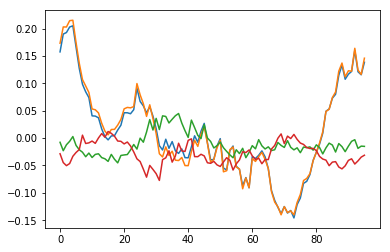

In [82]:
plt.plot(corr_from)
plt.show()

In [83]:
corr_to = np.array([df_by_date[df_by_date['tod'] == tod][['residual3_to', 'TMAX', 'TMIN', 'PRCP', 'SNOW']].corr().iloc[0, 1:5] for tod in range(4*24)])

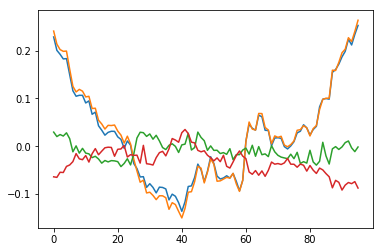

In [84]:
plt.plot(corr_to)
plt.show()

Blue (TMAX) and orange (TMIN) have the same clear pattern. More people take the taxi late at night when it's warm, and during the day and early evening when it's cold. Makes sense. There needs to be some nonlinearity to take this into account. TMAX and TMIN basically convey the same information, so I will only keep TMAX.

There also seems to be a pattern from precipitation, but it's small.

In [85]:
ss = StandardScaler()
weather_scaled = ss.fit_transform(df_by_date[['TMAX', 'PRCP', 'SNOW']])

In [86]:
X4 = scipy.sparse.hstack((X3, weather_scaled))

Try a simple neural network. 2-neuron network was not enough to remove the time-dependent component in the residuals, so I use a 5-neuron hidden layer.

In [164]:
nn_from = MLPRegressor(activation='logistic', hidden_layer_sizes=5)
nn_to = MLPRegressor(activation='logistic', hidden_layer_sizes=5)

In [165]:
nn_from.fit(X4, df_by_date['from'])

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=5, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [166]:
nn_from.score(X4, df_by_date['from'])

0.86682861123123778

In [167]:
nn_to.fit(X4, df_by_date['to'])

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=5, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [168]:
nn_to.score(X4, df_by_date['to'])

0.85133328172031841

The models appear to have mostly converged, despite the warning.

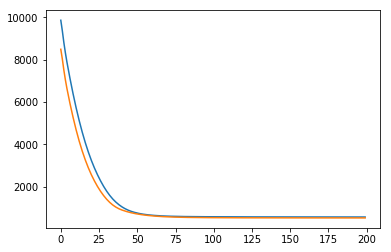

In [182]:
plt.plot(nn_from.loss_curve_)
plt.plot(nn_to.loss_curve_)
plt.show()

In [169]:
pred_nn_from = nn_from.predict(X4)
pred_nn_to = nn_to.predict(X4)
residual_nn_from = df_by_date['from'] - pred_nn_from
residual_nn_to = df_by_date['to'] - pred_nn_to

In [170]:
df_by_date['residual_nn_from'] = residual_nn_from
df_by_date['residual_nn_to'] = residual_nn_to

In [171]:
corr_nn_from = np.array([df_by_date[df_by_date['tod'] == tod][['residual_nn_from', 'TMAX', 'TMIN', 'PRCP', 'SNOW']].corr().iloc[0, 1:5] for tod in range(4*24)])

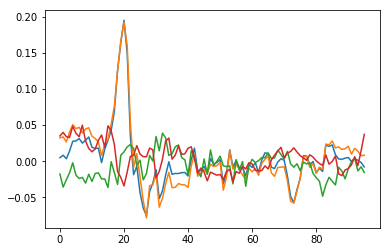

In [172]:
plt.plot(corr_nn_from)
plt.show()

In [173]:
corr_to = np.array([df_by_date[df_by_date['tod'] == tod][['residual_nn_to', 'TMAX', 'TMIN', 'PRCP', 'SNOW']].corr().iloc[0, 1:5] for tod in range(4*24)])

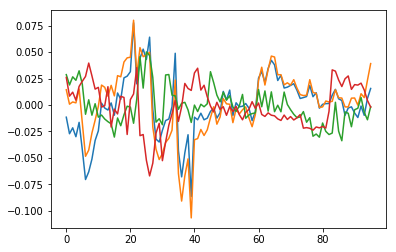

In [174]:
plt.plot(corr_to)
plt.show()

In [183]:
residual_nn_from.describe()

count    160609.000000
mean         -0.043062
std          33.998298
min        -244.664126
25%         -13.580100
50%          -1.354362
75%          14.454870
max         278.467032
Name: from, dtype: float64

In [184]:
residual_nn_to.describe()

count    160609.000000
mean         -0.052601
std          32.728015
min        -259.919552
25%         -13.600291
50%          -1.020326
75%          14.654643
max         268.427627
Name: to, dtype: float64

### Pipeline model
Now that I have the complete models for total taxi traffic to and from the Loop, make a pipeline model that can take me from a row containing date and weather to a prediction, and save the models as files, using pickle.

Input rows have 'dow', 'tod', 'holiday', 'TMAX', 'PRCP', 'SNOW' columns

In [212]:
class DateOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.ohe = OneHotEncoder()
        
    def fit(self, X, y=None):
        X['date'] = (24*4*df_by_date['dow'] + df_by_date['tod'])
        self.ohe.fit(X[['date']])
        return self
    
    def transform(self, X):
        X['date'] = (24*4*df_by_date['dow'] + df_by_date['tod'])
        return self.ohe.transform(X[['date']])

In [218]:
class HolidayTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[['holiday']]

In [196]:
class WeatherScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.ss = StandardScaler()
        
    def fit(self, X, y=None):
        X_weather = X[['TMAX', 'PRCP', 'SNOW']]
        self.ss.fit(X_weather)
        return self
    
    def transform(self, X):
        X_weather = X[['TMAX', 'PRCP', 'SNOW']]
        return self.ss.transform(X_weather)

In [219]:
model_from = Pipeline([('Transformers',
                       FeatureUnion([('Date', DateOneHotEncoder()),
                                    ('Holiday', HolidayTransformer()),
                                    ('Weather', WeatherScaler())])),
                     ('NN', MLPRegressor(activation='logistic',
                                         hidden_layer_sizes=5))])

In [220]:
model_from.fit(df_by_date, df_by_date['from'])

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Pipeline(memory=None,
     steps=[('Transformers', FeatureUnion(n_jobs=1,
       transformer_list=[('Date', DateOneHotEncoder()), ('Holiday', HolidayTransformer()), ('Weather', WeatherScaler())],
       transformer_weights=None)), ('NN', MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, b...=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False))])

In [221]:
model_from.score(df_by_date, df_by_date['from'])

0.86666106979213609

In [225]:
pickle.dump(model_from, open('model_from.pkl', 'wb'))

In [226]:
model_to = Pipeline([('Transformers',
                       FeatureUnion([('Date', DateOneHotEncoder()),
                                    ('Holiday', HolidayTransformer()),
                                    ('Weather', WeatherScaler())])),
                     ('NN', MLPRegressor(activation='logistic',
                                         hidden_layer_sizes=5))])

In [227]:
model_to.fit(df_by_date, df_by_date['to'])

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Pipeline(memory=None,
     steps=[('Transformers', FeatureUnion(n_jobs=1,
       transformer_list=[('Date', DateOneHotEncoder()), ('Holiday', HolidayTransformer()), ('Weather', WeatherScaler())],
       transformer_weights=None)), ('NN', MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, b...=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False))])

In [228]:
model_to.score(df_by_date, df_by_date['to'])

0.85117269820759733

In [229]:
pickle.dump(model_to, open('model_to.pkl', 'wb'))

### Old code

In [94]:
X1_hol = scipy.sparse.hstack((X1, from_loop_by_date[['holiday']]))

In [96]:
lr1_hol = LinearRegression()
lr1_hol.fit(X1_hol, from_loop_by_date['count'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [97]:
lr1_hol.score(X1_hol, from_loop_by_date['count'])

0.75230122966205815

In [98]:
pred1_hol = lr1_hol.predict(X1_hol)

In [100]:
(from_loop_by_date['count'] - pred1_hol).describe()

count    1.606090e+05
mean    -4.131570e-14
std      4.228616e+01
min     -1.841298e+02
25%     -2.755188e+01
50%     -7.632406e+00
75%      2.974001e+01
max      3.037774e+02
Name: count, dtype: float64

In [88]:
gs_from = GridSearchCV(nn_from, param_grid={'hidden_layer_sizes': [2, 5, 10, 20]})

In [89]:
gs_from.fit(X4, df_by_date['from'])

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_net

GridSearchCV(cv=None, error_score='raise',
       estimator=MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=2, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'hidden_layer_sizes': [2, 5, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [90]:
print(gs_from.best_params_, gs_from.best_score_)

{'hidden_layer_sizes': 20} 0.820048038805


In [91]:
gs_from.best_estimator_.score(X4, df_by_date['from'])

0.87142021330720554